In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.metrics import mean_squared_error
from lcdb.db import LCDB
from lcdb.analysis.util import LearningCurveExtractor, merge_curves

import sys
sys.path.append("../../2022-ecml/analysis")
# from utils_fit import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database import fit_model#, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

In [2]:
workflows = [
    "lcdb.workflow.sklearn.KNNWorkflow",
    "lcdb.workflow.sklearn.LibLinearWorkflow",
    "lcdb.workflow.sklearn.LibSVMWorkflow",
    "lcdb.workflow.sklearn.TreesEnsembleWorkflow"
]

openmlid = 11    # 3,6,11,12,14
workflow = workflows[0]

# retrieve learning curve objects
lcdb = LCDB()
df = lcdb.query(
    openmlids=[openmlid],
    workflows=[workflow],
    return_generator=False,
    processors={
        "learning_curve": LearningCurveExtractor(
            metrics=["error_rate"],
            folds=["train", "val"]
        )
    },
    show_progress=True
)

# group by configurations
config_cols = [c for c in df.columns if c.startswith("p:")]
df = df.groupby(config_cols).agg({"learning_curve": merge_curves})

100%|██████████| 25/25 [01:07<00:00,  2.68s/it]


In [3]:
max_schedule = df["learning_curve"].iloc[0].anchors_size
print(max_schedule)

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 500]


In [4]:
df["learning_curve"].apply(lambda x: x.pad_anchors_size(max_schedule, inplace=True))

p:metric       p:n_neighbors  p:pp@cat_encoder  p:pp@decomposition  p:pp@featuregen  p:pp@featureselector  p:pp@scaler  p:weights  p:p  p:pp@kernel_pca_kernel  p:pp@kernel_pca_n_components  p:pp@poly_degree  p:pp@selectp_percentile  p:pp@std_with_std
cosine         1              onehot            agglomerator        none             none                  minmax       uniform    1    linear                  0.250000                      2                 25                       True                 <lcdb.analysis.util.LearningCurve object at 0x...
                                                                                     selectp               none         distance   1    linear                  0.250000                      2                 90                       True                 <lcdb.analysis.util.LearningCurve object at 0x...
                                                                    poly             selectp               std          distance   1    linea

## Parametric model fitting

In [5]:
model_group = ['last1', 'pow4', 'mmf4', 'wbl4', 'exp4']

In [6]:
def curves_models_fitting(lc_data, model_names, extrapolate, input_mask, rep=5, verbose=True):
    fitting_results = []

    # counters for successful fits
    model_fit_stats = {model_name: {"successful_fits": 0, "total_fits": 0} for model_name in model_names}

    pbar = tqdm(total=len(lc_data) * len(model_names), smoothing=0, miniters=1)
    for lc in lc_data:
        schedule = lc.anchors_size  
        
        # ensure no NaN values in lc
        if np.any(~np.isnan(lc.values)):
            # compute mean
            lc = lc.values[0, 1, :, :, :, :, -1] if lc.is_iteration_wise_curve else lc.values[0, 1]
            scores = np.nanmean(lc, axis=(0, 1, 2)).squeeze() 
            
            for model_name in model_names:
                model_fit_stats[model_name]["total_fits"] += 1  

                try:    # fitting
                    if extrapolate: 
                        train_schedule = np.array(schedule)[:-input_mask] # training length
                        regress_target = np.array(scores)[:-input_mask]
                    else: 
                        train_schedule = np.array(schedule) 
                        regress_target = np.array(scores)
                    beta, model, fails_init, fails_fit = fit_model(
                        train_schedule, regress_target, 
                        np.array(schedule),  # extrapolation length
                        model_name, rep=rep, verbose=verbose)
                    
                    # predictions 
                    predictions = model(np.array(schedule))
                    #########################
                    # predictions[predictions>1] = 1
                    predictions[predictions<0] = 0
                    #########################

                    #MSE between predictions and actual scores
                    if extrapolate: 
                        mse = mean_squared_error(np.array(scores)[-input_mask:], predictions[-input_mask:])
                    else: # whole curve
                        mse = mean_squared_error(np.array(scores), predictions)

                    fitting_results.append({
                        "schedule": schedule,
                        "scores": scores,
                        "predictions": predictions,
                        "mse": mse,      
                        "curve_model": model_name,
                        "beta": beta,
                        "fails_init": fails_init,
                        "fails_fit": fails_fit
                    })

                    model_fit_stats[model_name]["successful_fits"] += 1

                except Exception as e:
                    # failed fitting
                    if verbose:
                        print(f"Failed to fit model {model_name} for current learning curve. Error: {e}")
                
                pbar.update(1)

        else:
            # skip NaN values learning curve
            continue

    pbar.close()
    return fitting_results, model_fit_stats

In [37]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=False, input_mask=0)
result_df = pd.DataFrame(fitting_results)

100%|██████████| 5100/5100 [11:03<00:00,  7.68it/s]


In [38]:
print("Results:")
for model_name in model_group:
    model_data = result_df[result_df['curve_model'] == model_name]
    if len(model_data) > 0:
        avg_mse = model_data["mse"].mean()
        std_mse = model_data["mse"].std()
        success_rate = (fit_stats[model_name]["successful_fits"] / fit_stats[model_name]["total_fits"]) * 100
        print(f"Model: {model_name}")
        print(f"  Average MSE: {avg_mse}")
        print(f"  Std of MSE: {std_mse}")
        print(f"  Fitting rate: {success_rate:.2f}% with {fit_stats[model_name]['successful_fits']} successful fits in total {fit_stats[model_name]['total_fits']}")

        actual_vs_pred = model_data[['scores', 'predictions']]

Results:
Model: last1
  Average MSE: 0.02411189080002446
  Std of MSE: 0.025478814660921268
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4
  Average MSE: 0.0004249606480230943
  Std of MSE: 0.0009362673791012399
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4
  Average MSE: 0.00024764023492554097
  Std of MSE: 0.00021054004638876718
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4
  Average MSE: 0.00028747394982246146
  Std of MSE: 0.00019133647058778682
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4
  Average MSE: 0.00029968732318623367
  Std of MSE: 0.00019071062387472211
  Fitting rate: 100.00% with 1020 successful fits in total 1020


### Extrapolate 

In [ ]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=1)
result_df_1 = pd.DataFrame(fitting_results)

In [ ]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=2)
result_df_2 = pd.DataFrame(fitting_results)

In [ ]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=3)
result_df_3 = pd.DataFrame(fitting_results)

In [ ]:
fitting_results, fit_stats = curves_models_fitting(df["learning_curve"], model_group, extrapolate=True, input_mask=4)
result_df_4 = pd.DataFrame(fitting_results)

In [11]:
# keep all subfigure the scale the same
overall_min = float('inf')
overall_max = float('-inf')
for i, model_name in enumerate(model_group):
    for j in range(4):
        model_data = globals()[f'result_df_{j + 1}'][globals()[f'result_df_{j + 1}']['curve_model'] == model_name]
        scores = np.array([score[-1] for score in model_data['scores']])
        predictions = np.array([pred[-1] for pred in model_data['predictions']])

        overall_min = min(overall_min, scores.min(), predictions.min())
        overall_max = max(overall_max, scores.max(), predictions.max())

In [12]:
fig, axs = plt.subplots(4, len(model_group), figsize=(5 * len(model_group), 5 * 4), dpi = 400)
for i, model_name in enumerate(model_group):
    for j in range(4):
        model_data = globals()[f'result_df_{j + 1}'][globals()[f'result_df_{j + 1}']['curve_model'] == model_name]
        scores = np.array([score[-1] for score in model_data['scores']])
        predictions = np.array([pred[-1] for pred in model_data['predictions']])

        label = f"Mask the last {j + 1} anchor"  
        ax = axs[j, i]  
        ax.scatter(x=scores, y=predictions, alpha=0.7, label=label)
        ax.plot([overall_min, overall_max], [overall_min, overall_max], 'r--', lw=2)
        ax.set_title(f'{model_name}, Mask last {j+1}, Predict last 1', fontsize=18)
        ax.set_xlabel('True Values', fontsize=16)
        ax.set_ylabel('Predicted Values', fontsize=16)
        ax.set_xlim(overall_min, overall_max) 
        ax.set_ylim(overall_min, overall_max) 
        ax.grid(True)

plt.tight_layout()
plt.show()

In [13]:
mse_last1 = []
mse_pow4 = []
mse_mmf4 = []
mse_wbl4 = []
mse_exp4 = []
std_last1 = []
std_pow4 = []
std_mmf4 = []
std_wbl4 = []
std_exp4 = []
for j in range(4):  
    print(f"The models are fitted by masking last {j + 1} anchor")
    for model_name in model_group:
        model_data = globals()[f'result_df_{j + 1}'][globals()[f'result_df_{j + 1}']['curve_model'] == model_name]
        
        if len(model_data) > 0:
            avg_mse = model_data["mse"].mean()
            std_mse = model_data["mse"].std()
            
            successful_fits = fit_stats[model_name]["successful_fits"]
            total_fits = fit_stats[model_name]["total_fits"]
            success_rate = (successful_fits / total_fits) * 100 if total_fits > 0 else 0
            
            print(f"Model: {model_name} (Mask last {j + 1} anchor)")
            print(f"  Average MSE: {avg_mse:.4f}")  
            print(f"  Std of MSE: {std_mse:.4f}")   
            print(f"  Fitting rate: {success_rate:.2f}% with {successful_fits} successful fits in total {total_fits}")
            if model_name == "last1":
                mse_last1.append(avg_mse)
                std_last1.append(std_mse)
            elif model_name == "pow4":
                mse_pow4.append(avg_mse)
                std_pow4.append(std_mse)
            elif model_name == "mmf4":
                mse_mmf4.append(avg_mse)
                std_mmf4.append(std_mse)
            elif model_name == "wbl4":
                mse_wbl4.append(avg_mse)
                std_wbl4.append(std_mse)
            elif model_name == "exp4":
                mse_exp4.append(avg_mse)
                std_exp4.append(std_mse)

        else:
            print(f"Model: {model_name} (Mask last {j + 1} anchor) has no data.")


The models are fitted by masking last 1 anchor
Model: last1 (Mask last 1 anchor)
  Average MSE: 0.0001
  Std of MSE: 0.0001
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4 (Mask last 1 anchor)
  Average MSE: 0.0005
  Std of MSE: 0.0015
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: mmf4 (Mask last 1 anchor)
  Average MSE: 0.0007
  Std of MSE: 0.0008
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: wbl4 (Mask last 1 anchor)
  Average MSE: 0.0010
  Std of MSE: 0.0040
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: exp4 (Mask last 1 anchor)
  Average MSE: 0.0018
  Std of MSE: 0.0076
  Fitting rate: 100.00% with 1020 successful fits in total 1020
The models are fitted by masking last 2 anchor
Model: last1 (Mask last 2 anchor)
  Average MSE: 0.0003
  Std of MSE: 0.0004
  Fitting rate: 100.00% with 1020 successful fits in total 1020
Model: pow4 (Mask last 2 anchor)
  Average MSE: 0.0011
  Std of 

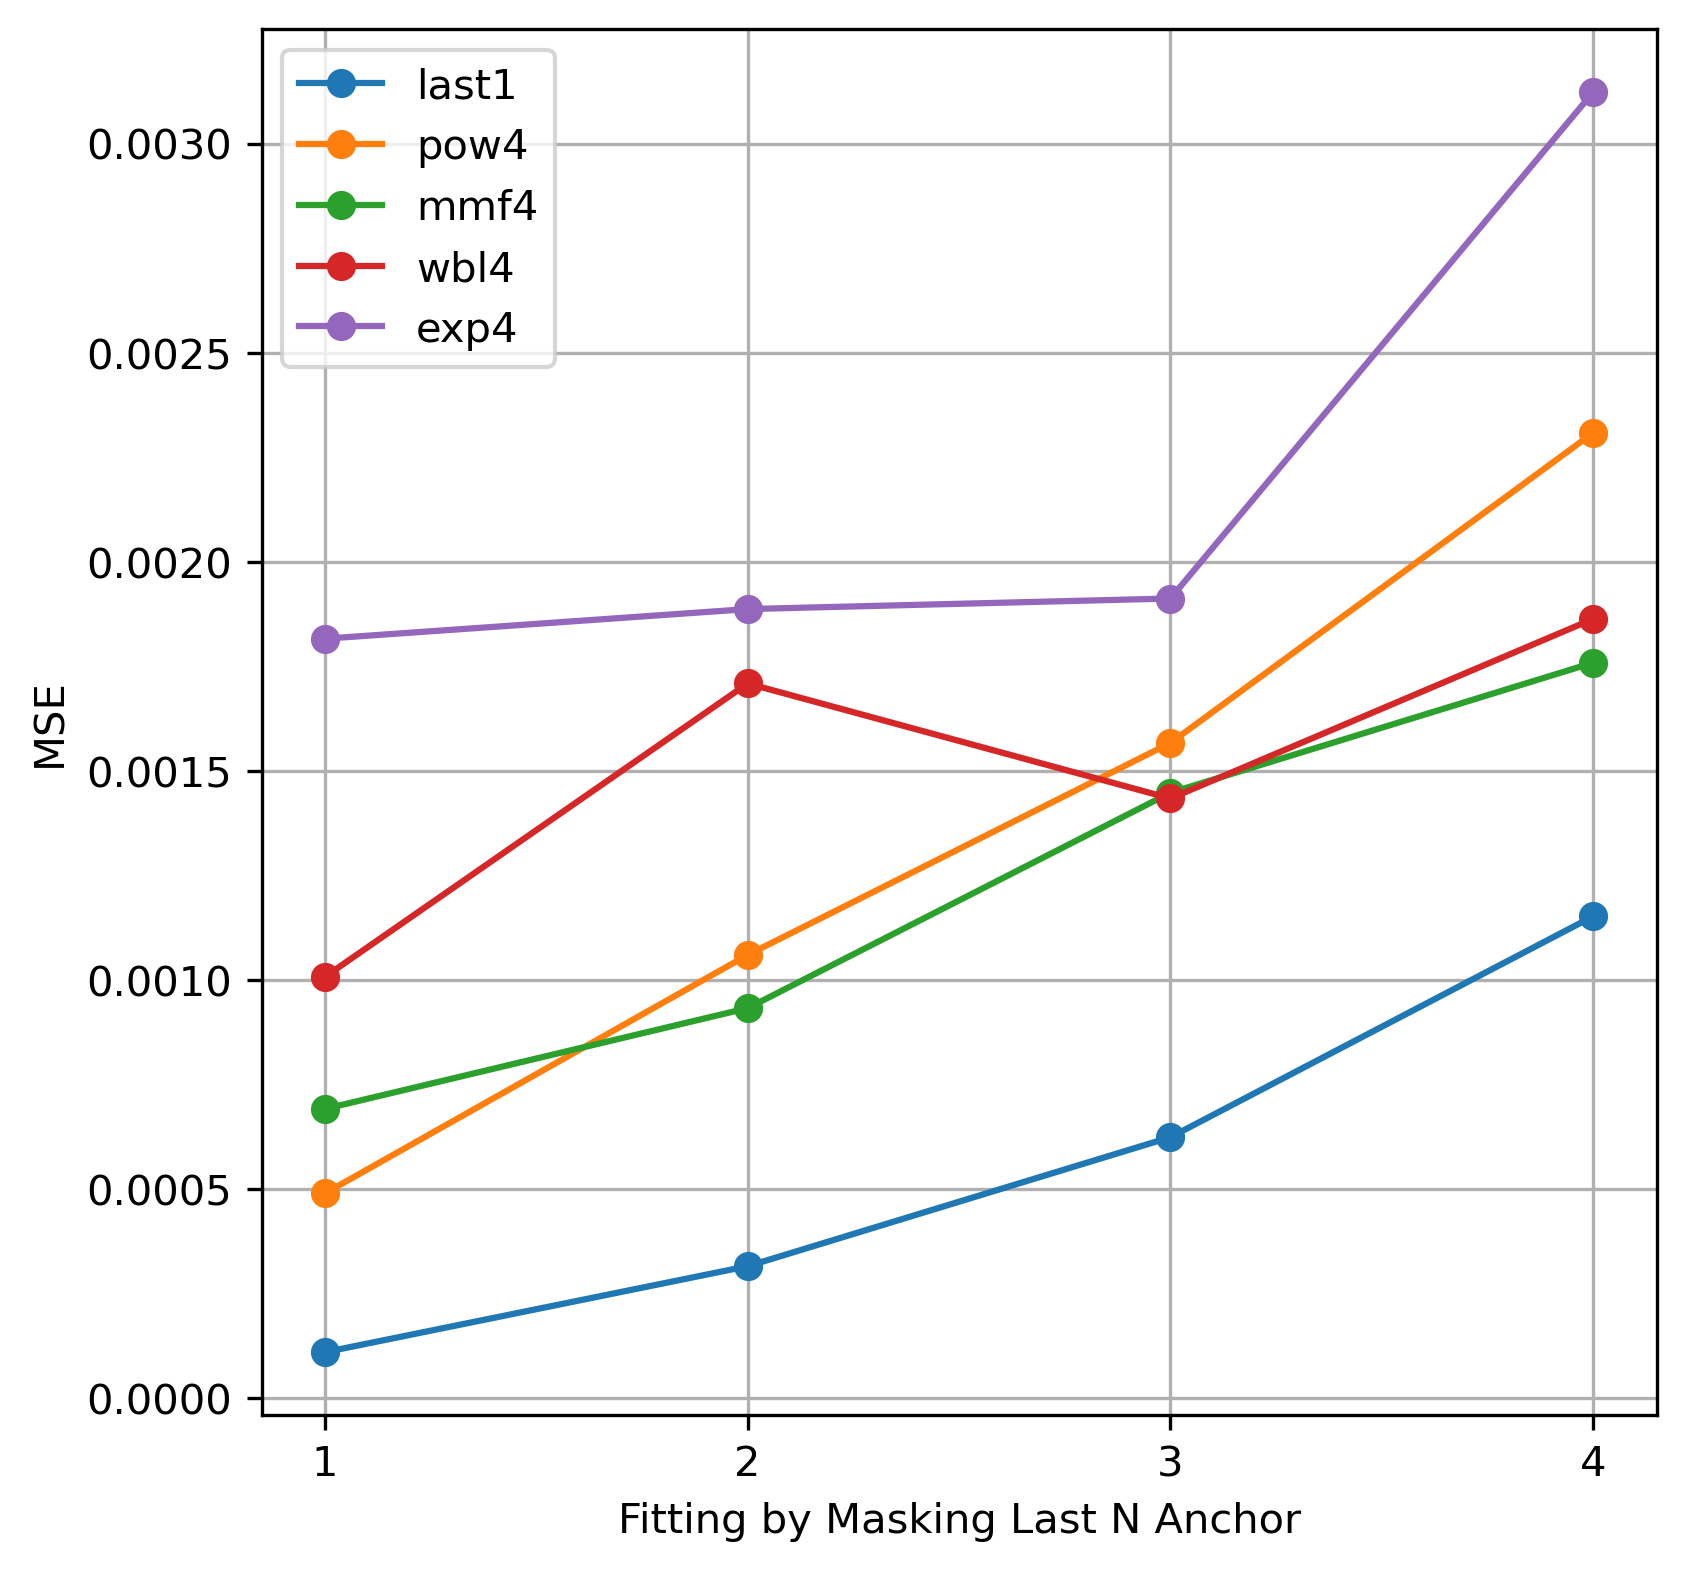

In [46]:
N_values = [1, 2, 3, 4]
plt.figure(figsize=(6, 6), dpi = 300)
plt.plot(N_values, mse_last1, marker='o', label='last1')
plt.plot(N_values, mse_pow4, marker='o', label='pow4')
plt.plot(N_values, mse_mmf4, marker='o', label='mmf4')
plt.plot(N_values, mse_wbl4, marker='o', label='wbl4')
plt.plot(N_values, mse_exp4, marker='o', label='exp4')
plt.xticks(N_values)
plt.xlabel('Fitting by Masking Last N Anchor')
plt.ylabel('MSE')
# plt.title('Fittings Different Parametric Models')

plt.legend()
plt.grid(True)
plt.show()

### one concrete example

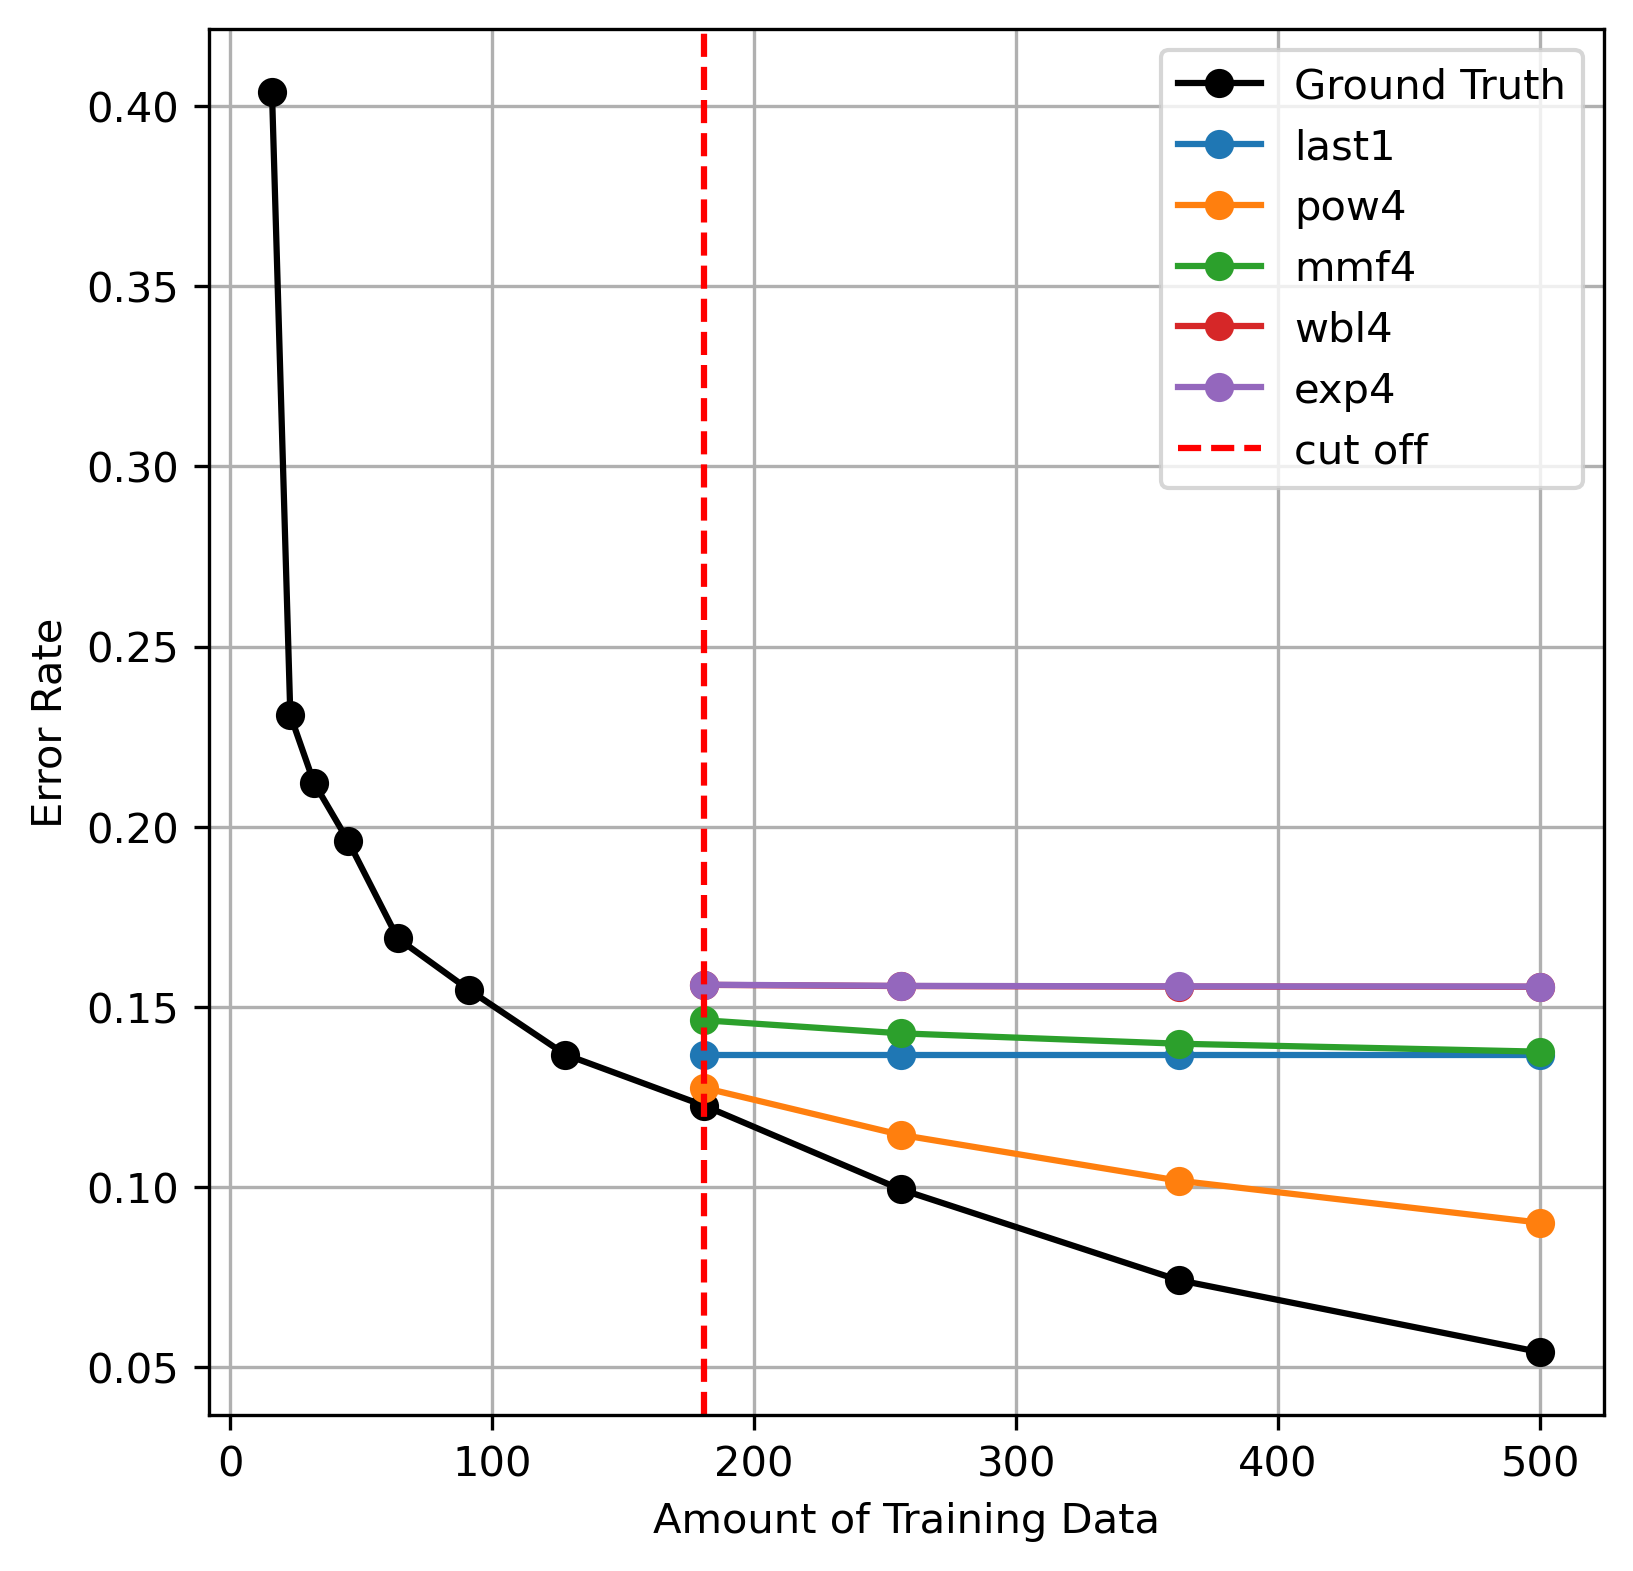

In [44]:
first_config = 0
x = result_df_4.at[first_config, 'schedule']
y = result_df_4.at[first_config, 'scores']
y_pred_last1 = result_df_4.at[first_config*5, 'predictions']
y_pred_pow4 = result_df_4.at[first_config*5+1, 'predictions']
y_pred_mmf4 = result_df_4.at[first_config*5+2, 'predictions']
y_pred_wbl4 = result_df_4.at[first_config*5+3, 'predictions']
y_pred_exp4 = result_df_4.at[first_config*5+4, 'predictions']

plt.figure(figsize=(6, 6), dpi = 300)
plt.plot(x, y, color = "black", marker='o', label="Ground Truth")
plt.plot(x[-4:], y_pred_last1[-4:], marker='o', label="last1")
plt.plot(x[-4:], y_pred_pow4[-4:], marker='o', label="pow4")
plt.plot(x[-4:], y_pred_mmf4[-4:], marker='o', label="mmf4")
plt.plot(x[-4:], y_pred_wbl4[-4:], marker='o', label="wbl4")
plt.plot(x[-4:], y_pred_exp4[-4:], marker='o', label="exp4")

plt.axvline(x=x[-4], color='red', linestyle='--', label="cut off")

plt.xlabel('Amount of Training Data')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()